fill missing with zeros output are all 0


# Setup

In [2]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from itertools import product
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import os

## Defining functions

In [4]:
def evaluate(metric, metric_name, true_values, predicted_values):
    print(f'{metric_name} : {metric(true_values, predicted_values)}')

In [5]:
def customized_MAPE(true_values, predicted_values):
    true_values, predicted_values = np.array(true_values), np.array(predicted_values)
    Mape = np.median(np.abs((true_values - predicted_values) / (true_values + 0.01)))
    return Mape

In [6]:
def train_test_split(data, train_size, test_size, path):
    train_data = []
    test_data = []
    #train part
    for i in range(train_size):
        name = path + 'm' + str(i + 1) + '.parquet'
        data = pd.read_parquet(name)
        train_data.append(data)
    #test part
    for j in range(test_size):
        name = path + 'm' + str(j + train_size + 1) + '.parquet'
        data = pd.read_parquet(name)
        test_data.append(data)
    return train_data, test_data

In [7]:
def load_data(path, force_update):
    urls = ['https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet',
                'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet',
                'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-03.parquet',
                'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-04.parquet']
    if os.path.exists(path) and (not force_update):
        pass
    else:
        if not os.path.exists(path): 
            os.mkdir(path)
        for index in range(len(urls)):
            response = requests.get(urls[index])
            name = path + 'm' + str(index + 1) + '.parquet'

            with open(name, 'wb') as f:
                f.write(response.content)
    datas = []
    for i in range(len(urls)):
        name = path + 'm' + str(i + 1) + '.parquet'
        data = pd.read_parquet(name)
        data.append(data)

    return datas
    
        
    

In [133]:
def date_format_modifier(data):  # Year/Month/Day
    data['month'] = pd.DataFrame([int(date.strftime("%m")) for date in data['PU_date']])
    data['day_month'] = pd.DataFrame([int(date.strftime("%d")) for date in data['PU_date']])
    data['day_week'] = pd.DataFrame([int(date.weekday()) for date in data['PU_date']])
    data = data.dropna()
    data = data.reindex(columns = ['PU_date', 'PULocationID', 'month','day_month', 'day_week', 'Demand'])
    return data

In [205]:
def add_features(data):  # run after merging datasets and modifing date
    # Lag features
    data['prev_day_demand'] = data.groupby(['PULocationID'])['Demand'].shift(1)

    data['prev_week_demand'] = data.groupby(['PULocationID'])['Demand'].shift(7)
    data['2prev_week_demand'] = data.groupby(['PULocationID'])['Demand'].shift(14)

    # Summary features
    shifted = data['Demand'].shift(window_size - 1)
    window = shifted.rolling(window = window_size)
    data['pre_min_week_demand'] = window.min()
    data['pre_mean_week_demand'] = window.mean()
    data['pre_max_week_demand'] = window.max()
    data['pre_std_week_demand'] = window.std()

    data = data.dropna()

    return data

In [66]:
def grouping_by(data, group_list):
    data_grouped = data.groupby(group_list, as_index = False)['extra'].count()
    data_grouped = data_grouped.rename(columns={'extra' : 'Demand'})

    return data_grouped

In [11]:
def clearing_data_noise(datas, months):
    clean_datas = []
    for index in range(len(datas)):
        month = months[index]
        data = datas[index]

        clean_data = data[[int(date.strftime("%m")) == month for date in data['tpep_pickup_datetime']]]
        clean_data = clean_data.dropna()
        clean_datas.append(clean_data)
    return clean_datas

In [12]:
def grid_search(model, test_parameters, train_data, cv = None):
    gs = GridSearchCV(estimator = model, param_grid = test_parameters, scoring = 'neg_root_mean_squared_error', cv = cv, n_jobs = -1)
    gs.fit(train_data[train_list], train_data['Demand'])
    return gs.best_params_, gs.best_score_

In [13]:
def point_predict(model, train_data, test_data):

    model.fit(train_data[train_list], train_data['Demand'])


    yhat_train = model.predict(train_data[train_list])
    yhat_test = model.predict(test_data[train_list])

    return yhat_train, yhat_test

In [14]:
def point_predict_visualizer(train_data, test_data, yhat_train, yhat_test):

    predicted_train_df = train_data.copy(deep = True)
    predicted_test_df = test_data.copy(deep = True)
    predicted_train_df['Predicted'] = yhat_train
    predicted_test_df['Predicted'] = yhat_test

    train_data = train_data.groupby('day_year')['Demand'].sum()
    test_data = test_data.groupby('day_year')['Demand'].sum()
    predicted_train_df = predicted_train_df.groupby('day_year')['Predicted'].sum()
    predicted_test_df = predicted_test_df.groupby('day_year')['Predicted'].sum()

    plt.title('Train')
    plt.plot(train_data)
    plt.plot(predicted_train_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

    plot_length = len(test_data)
    plt.title('Test')
    plt.plot(test_data)
    plt.plot(predicted_test_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

In [15]:
def concating_data(datas):
    data_combined = pd.concat(datas, axis=0)
    return data_combined

In [16]:
def evaluation(model_name, train_data, test_data, yhat_train, yhat_test):
    print(f'{model_name} train scores:')


    evaluate(mean_absolute_error, 'MAE', train_data['Demand'], yhat_train)
    evaluate(mean_squared_error, 'MSE', train_data['Demand'], yhat_train)
    evaluate(customized_MAPE, 'MAPE', train_data['Demand'], yhat_train)

    print(f'{model_name} test scores:')


    evaluate(mean_absolute_error, 'MAE', test_data['Demand'], yhat_test)
    evaluate(mean_squared_error, 'MSE', test_data['Demand'], yhat_test)
    evaluate(customized_MAPE, 'MAPE', test_data['Demand'], yhat_test)


In [17]:
def sort_metrics_values(metrics_values):
    metrics_train_values  = metrics_values['train']
    metrics_test_values = metrics_values['test']

    sorted_train_metrics = sorted(metrics_train_values, key=lambda x: x[1]['RMSE'], reverse = True)
    sorted_test_metrics = sorted(metrics_test_values, key=lambda x: x[1]['RMSE'], reverse = True)

    sorted_metrics_values = {'train': sorted_train_metrics, 'test': sorted_test_metrics}
    return sorted_metrics_values

In [18]:
def evaluate_each_location(fitted_model, train_data, test_data):
    metrics_values = {'train' : [], 'test': []}
    for loc_id in range(loc_id_num):
        sample_train_data = train_data[train_data['PULocationID'] == loc_id]
        sample_test_data = test_data[test_data['PULocationID'] == loc_id]
        if len(sample_train_data) != 0:
            yhat_train_sample = fitted_model.predict(sample_train_data[train_list])
            metrics_values['train'].append([loc_id, {'RMSE' : np.sqrt(mean_squared_error(sample_train_data["Demand"], yhat_train_sample)),
                                                      'MAE' : mean_absolute_error(sample_train_data["Demand"], yhat_train_sample)}])
        if len(sample_test_data) != 0:
            yhat_test_sample = fitted_model.predict(sample_test_data[train_list])
            metrics_values['test'].append([loc_id, {'RMSE' : np.sqrt(mean_squared_error(sample_test_data["Demand"], yhat_test_sample)),
                                                      'MAE' : mean_absolute_error(sample_test_data["Demand"], yhat_test_sample)}])
    return sort_metrics_values(metrics_values)

In [19]:
def get_locations_mean_demand(locations_id, data):
    sum_demands = []
    for location_id in locations_id:
        sum_demands.append({location_id : data[data['PULocationID'] == location_id]['Demand'].mean()})
    return sum_demands

In [20]:
def day_of_year_modifier(data, year):
    data['day_year'] = 0

    # Loop over each row in the DataFrame
    for index, row in data.iterrows():
        # Get the day and month values from the current row
        day = int(row['day_month'])
        month = int(row['month'])
        
        # Calculate the day number for the current row using datetime
        date = datetime.datetime(year=year, month=month, day=day)
        day_number = (date - datetime.datetime(year=year, month=1, day=1)).days + 1
        
        # Store the day number in the 'day_number' column for the current row
        data.at[index, 'day_year'] = day_number
    return data

In [123]:
def fill_missing_demands(data):
    data = data.reset_index(drop = True)
    
    start_date = data['PU_date'].min()
    end_date = data['PU_date'].max()

    all_loc_dfs = []
    for location_id in range(1, loc_id_num):
        filled_with_zero = pd.DataFrame({'PU_date': pd.date_range(start=start_date, end=end_date), 'PULocationID': location_id})
            
        filled_with_zero['Demand'] = 0
        for i in range(len(filled_with_zero)):
            loc_date_row = data[(data['PU_date']==filled_with_zero['PU_date'][i]) 
                                &(data['PULocationID']==filled_with_zero['PULocationID'][i])]
            if not loc_date_row.empty:
                filled_with_zero['Demand'][i] = loc_date_row['Demand']
                
        all_loc_dfs.append(filled_with_zero)
    filled_data = pd.concat(all_loc_dfs).reset_index(drop=True)
    return filled_data

In [110]:
def keep_date_day(data):
    data['PU_date'] = pd.to_datetime(data.tpep_pickup_datetime.dt.date)
    return data

# initialization and loading dataset

## Constant values

In [212]:
group_list = ['PU_date', 'PULocationID']
train_list = ['day_year', 'day_month', 'day_week', 'prev_day_demand', 
              'prev_week_demand', '2prev_week_demand', 
              'pre_min_week_demand', 'pre_mean_week_demand', 
              'pre_max_week_demand', 'pre_std_week_demand']
path = 'datasets/'
loc_id_num = 266
year = 2023
train_size = 3
test_size = 1
window_size = 7

## Load dataset

In [ ]:
data = load_data(path, force_update = False)

## Train Test Split

In [24]:
train_data, test_data = train_test_split(data, train_size, test_size, path)

# Preprocessing

In [34]:
train_data = clearing_data_noise(train_data, [1,2,3])
test_data = clearing_data_noise(test_data, [4])

In [108]:
train_data_concated = concating_data(train_data)
test_data_concated = concating_data(test_data)

In [111]:
train_data_days = keep_date_day(train_data_concated)
test_data_days = keep_date_day(test_data_concated)

In [115]:
train_grouped = grouping_by(train_data_days, group_list)
test_grouped = grouping_by(test_data_days, group_list)

In [ ]:
train_filled = fill_missing_demands(train_grouped)
test_filled = fill_missing_demands(test_grouped)

In [208]:
train_date_modified = date_format_modifier(train_filled)
test_date_modified = date_format_modifier(test_filled)

In [209]:
train_feature_modified = add_features(train_date_modified)
test_feature_modified = add_features(test_date_modified)

In [210]:
train_feature_modified

,PU_date,PULocationID,month,day_month,day_week,Demand,prev_day_demand,prev_week_demand,2prev_week_demand,pre_min_week_demand,pre_mean_week_demand,pre_max_week_demand,pre_std_week_demand
14,2023-01-15,1,1,15,6,19,7.0,12.0,40.0,6.0,13.000000,27.0,6.928203
15,2023-01-16,1,1,16,0,21,19.0,14.0,31.0,4.0,9.714286,14.0,4.029652
16,2023-01-17,1,1,17,1,18,21.0,4.0,27.0,4.0,10.000000,14.0,3.872983
17,2023-01-18,1,1,18,2,10,18.0,9.0,7.0,4.0,9.142857,14.0,3.484660
18,2023-01-19,1,1,19,3,9,10.0,8.0,14.0,4.0,10.571429,21.0,5.711309
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23845,2023-03-27,265,3,27,0,42,75.0,35.0,56.0,35.0,59.571429,74.0,15.714719
23846,2023-03-28,265,3,28,1,49,42.0,40.0,48.0,35.0,58.428571,74.0,15.883504
23847,2023-03-29,265,3,29,2,40,49.0,53.0,61.0,35.0,55.285714,74.0,16.306586
23848,2023-03-30,265,3,30,3,69,40.0,44.0,66.0,35.0,51.714286,74.0,14.693698


In [211]:
modified_train = day_of_year_modifier(train_feature_modified, year)
modified_test = day_of_year_modifier(test_feature_modified, year)

C:\Users\bardia\AppData\Local\Temp\ipykernel_3408\3292262934.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day_year'] = 0
C:\Users\bardia\AppData\Local\Temp\ipykernel_3408\3292262934.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day_year'] = 0


# Model Training

## **Linear Regression**

### Grid search to find best hyper parameters

In [213]:
model = Ridge()
best_params, best_score = grid_search(model, {'alpha':[1, 10, 100, 1000, 1000]}, modified_train, cv = 5)
print(best_params, best_score)

{'alpha': 1000} -93.38649649477274


In [214]:
model = Ridge(**best_params)
yhat_train, yhat_test = point_predict(model, modified_train, modified_test)

### Visualization

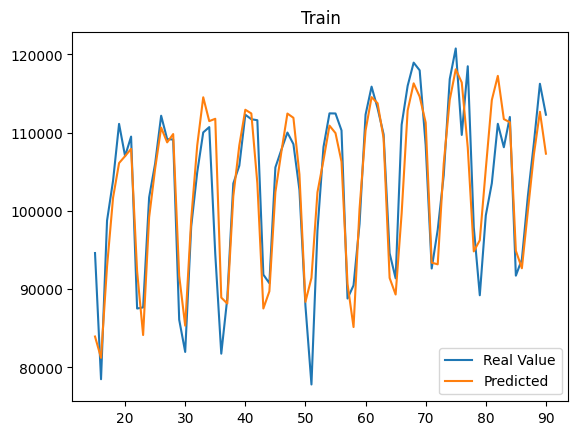

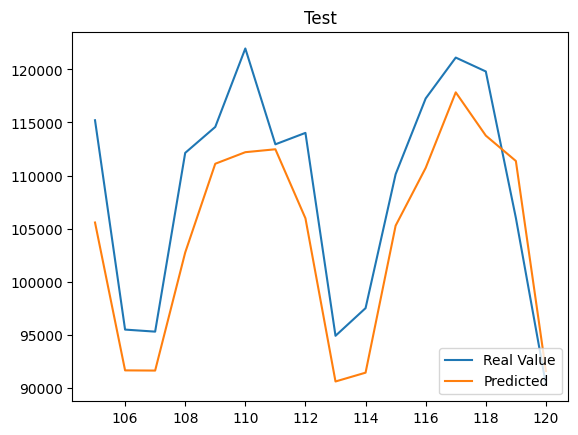

In [215]:
point_predict_visualizer(modified_train, modified_test, yhat_train, yhat_test)

### Evaluation

In [216]:
evaluation('Ridge Regression', modified_train, modified_test, yhat_train, yhat_test)  # for whole data

Ridge Regression train scores:
MAE : 32.46157855785415
MSE : 9767.490903004207
MAPE : 0.7775865881890273
Ridge Regression test scores:
MAE : 34.987968173771385
MSE : 8008.169985509116
MAPE : 1.4849452646197112


In [217]:
sorted_metrics_values = evaluate_each_location(model, modified_train, modified_test)  # for each location

In [218]:
sorted_metrics_values['train'][:10]

[[237, {'RMSE': 514.9065336868555, 'MAE': 373.30303759983605}],
 [236, {'RMSE': 493.32595282109355, 'MAE': 347.47918635530215}],
 [161, {'RMSE': 483.7436808780267, 'MAE': 344.62389814530235}],
 [132, {'RMSE': 478.30874503085727, 'MAE': 385.6513992194823}],
 [138, {'RMSE': 387.4636302761951, 'MAE': 311.6617328866626}],
 [79, {'RMSE': 369.76412828617094, 'MAE': 256.58483248327246}],
 [246, {'RMSE': 353.2082610043413, 'MAE': 254.95148849496735}],
 [230, {'RMSE': 344.0114418910671, 'MAE': 261.69471898917277}],
 [163, {'RMSE': 281.8503133912625, 'MAE': 208.3851705843139}],
 [162, {'RMSE': 279.25950488886957, 'MAE': 202.99294803822698}]]

In [219]:
modified_train['Demand'].mean(), modified_test['Demand'].mean()

(389.07164846077455, 410.0764150943396)

In [220]:
bad_predicted_locations_id = [value[0] for value in sorted_metrics_values['train'][:10]]
get_locations_mean_demand(bad_predicted_locations_id, modified_train)

[{237: 4843.723684210527},
 {236: 4406.171052631579},
 {161: 4859.763157894737},
 {132: 5042.828947368421},
 {138: 3249.934210526316},
 {79: 2570.3815789473683},
 {246: 1626.0657894736842},
 {230: 3514.1447368421054},
 {163: 3007.0789473684213},
 {162: 3731.3289473684213}]

In [221]:
bad_predicted_locations_id = [value[0] for value in sorted_metrics_values['test'][:10]]
get_locations_mean_demand(bad_predicted_locations_id, modified_test)

[{132: 5987.9375},
 {138: 3938.375},
 {237: 5255.4375},
 {236: 4702.5625},
 {142: 3876.25},
 {161: 4867.5},
 {246: 1668.75},
 {163: 3241.6875},
 {162: 3713.4375},
 {170: 3190.125}]

## **Gradient Boosting Regressor**

### Grid search to find best hyper parameters

In [256]:
param_test = {'max_depth':range(2,10,2), 'min_child_weight':range(1,6,2)}

params = {"objective": "reg:squarederror", "tree_method": "gpu_hist", 'n_estimators':140, 'learning_rate':0.1, 'max_depth':5,
         'min_child_weight':1, 'gamma':0, 'subsample':0.8, 'colsample_bytree':0.8, 'seed':27}

best_params, best_score = grid_search(model = xgb.XGBRegressor(**params), test_parameters = param_test, train_data = modified_train, cv = 5)
print(best_params, best_score)

{'max_depth': 2, 'min_child_weight': 3} -129.96563188441945


In [81]:
params.update(best_params)
param_test = {'gamma':[i/10.0 for i in range(0,5)]}
best_params, best_score = grid_search(model = xgb.XGBRegressor(**params), test_parameters = param_test, train_data = modified_train, cv = 5)
print(best_params, best_score)

{'gamma': 0.0} -238.60198873503435


In [85]:
params.update(best_params)
param_test = {'subsample':[i/10.0 for i in range(6,10)], 'colsample_bytree':[i/10.0 for i in range(6,10)]}
best_params, best_score = grid_search(model = xgb.XGBRegressor(**params), test_parameters = param_test, train_data = modified_train, cv = 5)
print(best_params, best_score)

{'colsample_bytree': 0.6, 'subsample': 0.9} -237.0204546297031


In [87]:
params.update(best_params)
param_test = {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}
best_params, best_score = grid_search(model = xgb.XGBRegressor(**params), test_parameters = param_test, train_data = modified_train, cv = 5)
print(best_params, best_score)

{'reg_alpha': 1} -237.02005974356038


In [90]:
params.update(best_params)
param_test = {'n_estimators':list(range(1000, 5001, 500)), 'learning_rate':[0.01]}
best_params, best_score = grid_search(model = xgb.XGBRegressor(**params), test_parameters = param_test, train_data = modified_train, cv = 5)
print(best_params, best_score)

{'learning_rate': 0.01, 'n_estimators': 1500} -236.59626847393665


In [95]:
params.update(best_params)
param_test = {'n_estimators':list(range(15000, 20001, 500)), 'learning_rate':[0.001]}
best_params, best_score = grid_search(model = xgb.XGBRegressor(**params), test_parameters = param_test, train_data = modified_train, cv = 5)
print(best_params, best_score)

{'learning_rate': 0.001, 'n_estimators': 15000} -236.53642284774014


### Training with costant parameters

In [222]:
dtrain_reg = xgb.DMatrix(modified_train[train_list].values, modified_train['Demand'].values, enable_categorical=True)
dtest_reg = xgb.DMatrix(modified_test[train_list].values, modified_test['Demand'].values, enable_categorical=True)

#params.update(best_params)
params = {'learning_rate': 0.001, 'n_estimators': 15000, 'reg_alpha': 1, 'colsample_bytree': 0.6, 
          'subsample': 0.9, 'gamma': 0.0, 'max_depth': 2, 'min_child_weight': 5}
model = xgb.XGBRegressor(**params)
yhat_train, yhat_test = point_predict(model, modified_train, modified_test)

### Visualization

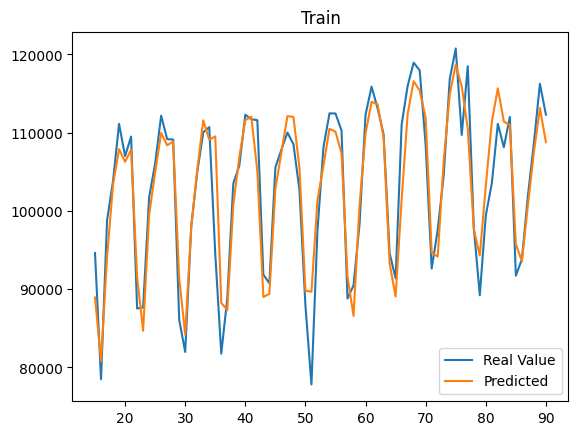

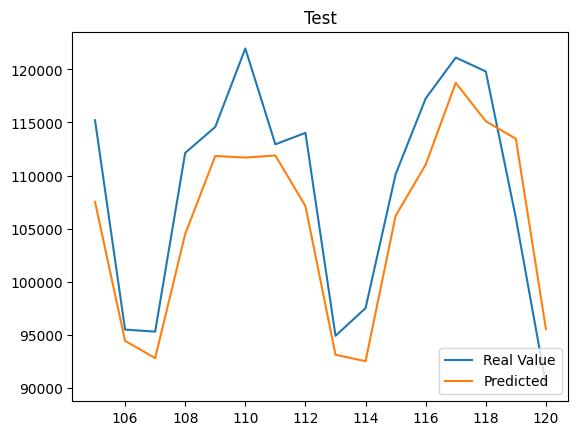

In [223]:
point_predict_visualizer(modified_train, modified_test, yhat_train, yhat_test)

### Evaluation

In [225]:
evaluation('XGB', modified_train, modified_test, yhat_train, yhat_test)  # for whole data

XGB train scores:
MAE : 27.487142819811357
MSE : 6946.822740820959
MAPE : 0.3859865391849715
XGB test scores:
MAE : 31.541300726218044
MSE : 9265.963983238245
MAPE : 0.3755710939546439


In [226]:
sorted_metrics_values = evaluate_each_location(model, modified_train, modified_test)  # for each location

In [227]:
sorted_metrics_values['train'][:10]

[[161, {'RMSE': 360.9637676137222, 'MAE': 253.66701146175987}],
 [138, {'RMSE': 358.1164355673752, 'MAE': 277.4259996916118}],
 [236, {'RMSE': 356.689871340318, 'MAE': 261.23704448499177}],
 [237, {'RMSE': 337.570943657596, 'MAE': 255.97582365337172}],
 [132, {'RMSE': 327.4710187746278, 'MAE': 264.47364887438323}],
 [246, {'RMSE': 327.4512460862065, 'MAE': 237.69990780479029}],
 [79, {'RMSE': 312.43243296688934, 'MAE': 208.2730841385691}],
 [230, {'RMSE': 305.5088455095847, 'MAE': 234.72532573499177}],
 [163, {'RMSE': 253.49436327545538, 'MAE': 183.97975560238487}],
 [162, {'RMSE': 252.02913773736753, 'MAE': 187.09063078227797}]]

In [228]:
modified_train['Demand'].mean(), modified_test['Demand'].mean()

(389.07164846077455, 410.0764150943396)

In [229]:
bad_predicted_locations_id = [value[0] for value in sorted_metrics_values['train'][:10]]
get_locations_mean_demand(bad_predicted_locations_id, modified_train)

[{161: 4859.763157894737},
 {138: 3249.934210526316},
 {236: 4406.171052631579},
 {237: 4843.723684210527},
 {132: 5042.828947368421},
 {246: 1626.0657894736842},
 {79: 2570.3815789473683},
 {230: 3514.1447368421054},
 {163: 3007.0789473684213},
 {162: 3731.3289473684213}]

In [230]:
bad_predicted_locations_id = [value[0] for value in sorted_metrics_values['test'][:10]]
get_locations_mean_demand(bad_predicted_locations_id, modified_test)

[{132: 5987.9375},
 {237: 5255.4375},
 {138: 3938.375},
 {236: 4702.5625},
 {142: 3876.25},
 {170: 3190.125},
 {161: 4867.5},
 {163: 3241.6875},
 {246: 1668.75},
 {162: 3713.4375}]

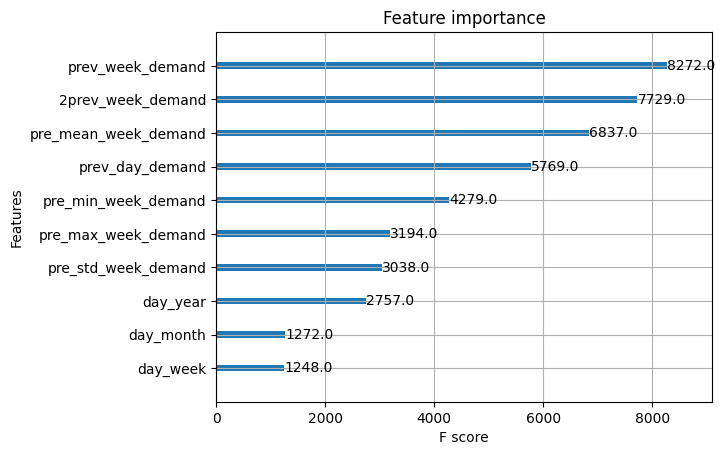

In [231]:
xgb.plot_importance(model)
plt.show()